# Import Libraries

In [1]:
import sys, os, re
import CityScapes_labels as labels
from CityScapes import CityScapesInterface
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataroot = '../../Datasets/cityscapes'
list_of_classes = ['__bgr__', 'car', 'person']

# Testing the interface

In [3]:
datasetinterface = CityScapesInterface(dataroot, list_of_classes, labels)

## Testing Bounding Boxes

In [4]:
datasetinterface.load_bounding_boxes(0)

{'classes': tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 24, 24, 26]),
 'bboxes': tensor([[ 609.,  420.,  807.,  532.],
         [ 145.,  429.,  304.,  502.],
         [ 145.,  429.,  304.,  502.],
         [1962.,  488., 2047.,  526.],
         [1512.,  446., 1660.,  499.],
         [1479.,  456., 1634.,  514.],
         [1862.,  481., 1937.,  500.],
         [1872.,  486., 1956.,  513.],
         [1721.,  450., 1864.,  509.],
         [ 145.,  429.,  304.,  502.],
         [ 887.,  446.,  913.,  498.],
         [ 901.,  444.,  934.,  498.],
         [ 609.,  420.,  807.,  532.]])}

## Testing Semnatic masks

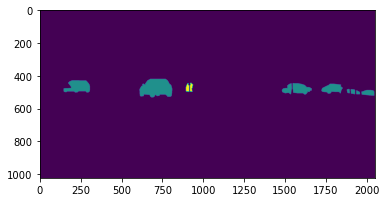

In [5]:
plt.imshow(datasetinterface.load_semantic_mask(0))
plt.show()

## Testing Instance masks

In [6]:
instance_masks = datasetinterface.load_instance_masks(0)

[0 2]


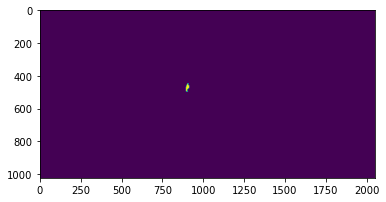

[0 2]


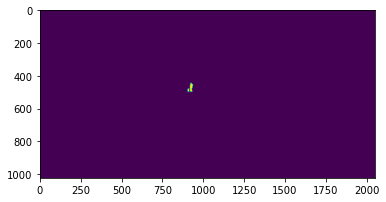

[0 1]


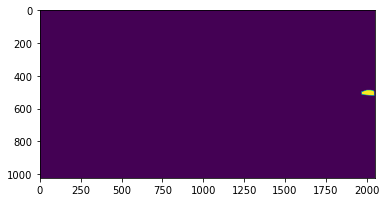

[0 1]


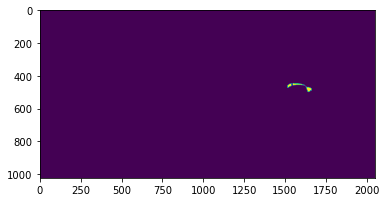

[0 1]


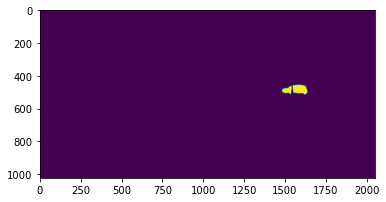

[0 1]


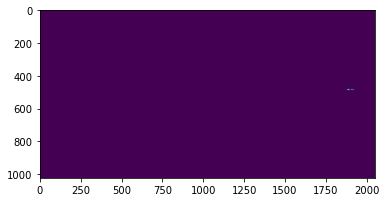

[0 1]


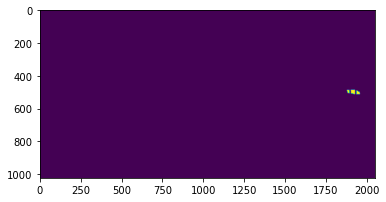

[0 1]


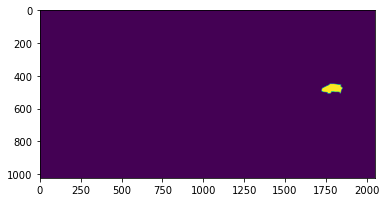

[0 1]


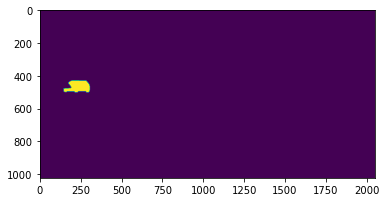

[0 1]


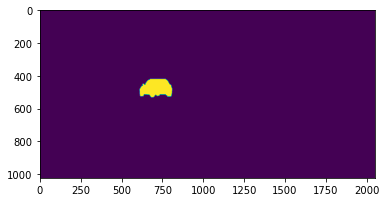

In [7]:
for mask in instance_masks:
    print(np.unique(mask))
    plt.imshow(mask)
    plt.show()

## Testing Bounding Boxes and Masks

In [8]:
label = datasetinterface.load_boundingBoxes_and_masks(1)

In [9]:
label

{'classes': tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]),
 'bboxes': tensor([[1159.,  425., 1184.,  450.],
         [1278.,  418., 1304.,  444.],
         [ 718.,  428.,  778.,  470.],
         [1877.,  405., 1934.,  436.],
         [1631.,  428., 1720.,  465.],
         [1558.,  416., 1626.,  443.],
         [1499.,  417., 1570.,  448.],
         [1448.,  420., 1514.,  461.],
         [ 192.,  444.,  367.,  536.],
         [ 637.,  438.,  700.,  483.],
         [   0.,  447.,   68.,  569.],
         [1167.,  420., 1234.,  471.],
         [1101.,  422., 1147.,  455.],
         [1063.,  422., 1111.,  463.],
         [1010.,  415., 1084.,  477.]]),
 'masks': [tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
  tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ...

tensor(26)


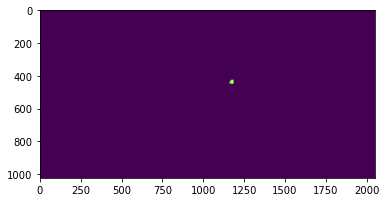

tensor(26)


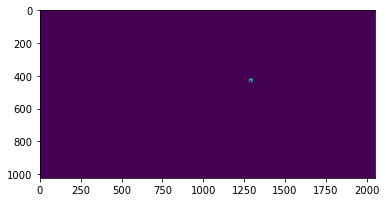

tensor(26)


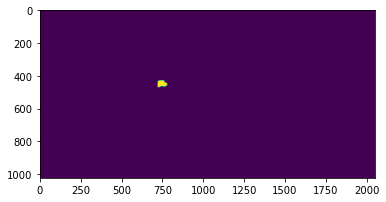

tensor(26)


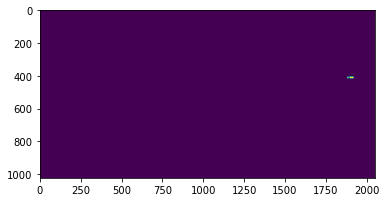

tensor(26)


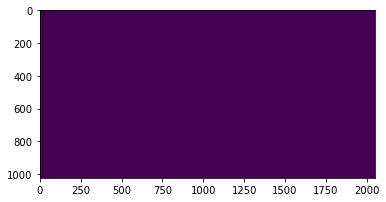

tensor(26)


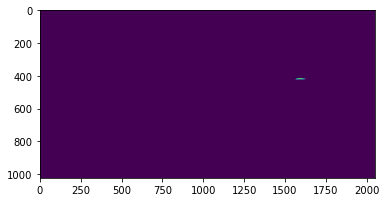

tensor(26)


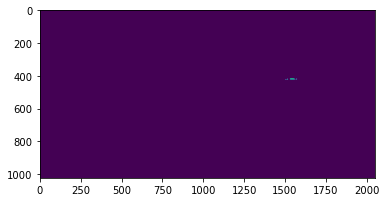

tensor(26)


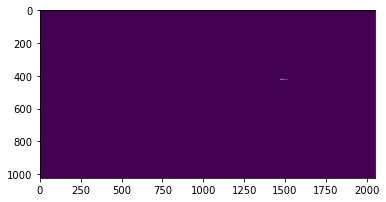

tensor(26)


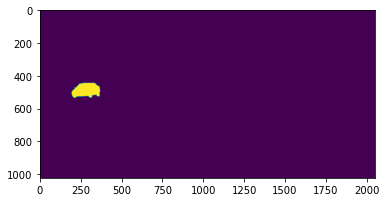

tensor(26)


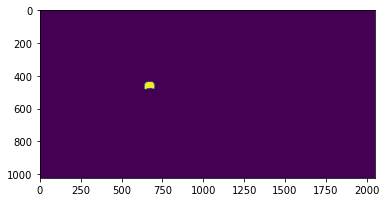

tensor(26)


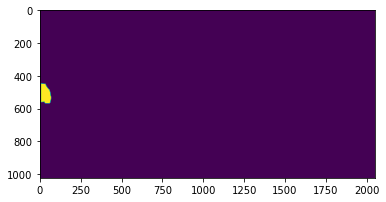

tensor(26)


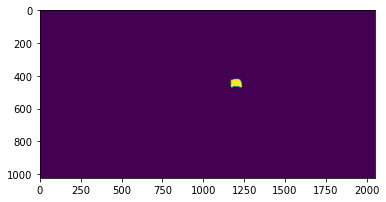

tensor(26)


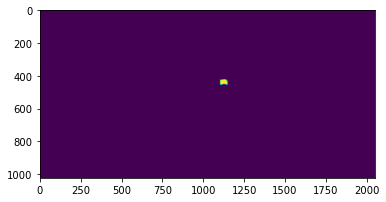

tensor(26)


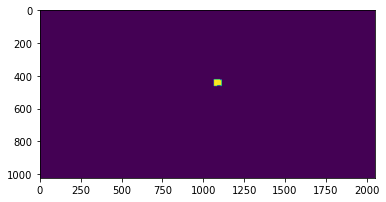

tensor(26)


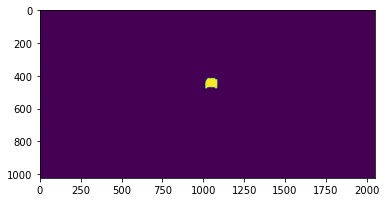

In [10]:
for idx in range(len(label['masks'])):
    print(label['classes'][idx])
    plt.imshow(label['masks'][idx])
    plt.show()

## Testing __getitem__ method

In [11]:
datasetinterface[0]

(0,
 tensor([[[ 1.1682,  1.2024,  1.2367,  ..., -1.2122, -1.2122, -1.2122],
          [ 1.1682,  1.1853,  1.2024,  ..., -1.1951, -1.2122, -1.2122],
          [ 1.1853,  1.2024,  1.1853,  ..., -1.2122, -1.2122, -1.2122],
          ...,
          [-0.3559, -0.3731, -0.3731,  ..., -0.8354, -0.8697, -0.8697],
          [-0.3559, -0.3731, -0.3731,  ..., -0.8183, -0.8354, -0.8697],
          [-0.3559, -0.3731, -0.3731,  ..., -0.8526, -0.8354, -0.8354]],
 
         [[ 1.5663,  1.5838,  1.6013,  ..., -1.2699, -1.2699, -1.2699],
          [ 1.5313,  1.5663,  1.5838,  ..., -1.2524, -1.2524, -1.2524],
          [ 1.5313,  1.5488,  1.5663,  ..., -1.2524, -1.2524, -1.2524],
          ...,
          [-0.3070, -0.3245, -0.3245,  ..., -0.8147, -0.8322, -0.8497],
          [-0.3070, -0.3245, -0.3245,  ..., -0.7797, -0.7972, -0.8322],
          [-0.3070, -0.3245, -0.3245,  ..., -0.7972, -0.7972, -0.8147]],
 
         [[ 1.3477,  1.3477,  1.3826,  ..., -1.5804, -1.5804, -1.5804],
          [ 1.3129,  1.3